Each peak in the LFC file appears to be very flat on the top. This explores that. 
It turned out that it was because of the way that I was normalizing peaks. 
super_gauss_demo_for_lars.ipynb shows the correct normalization.

In [1]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

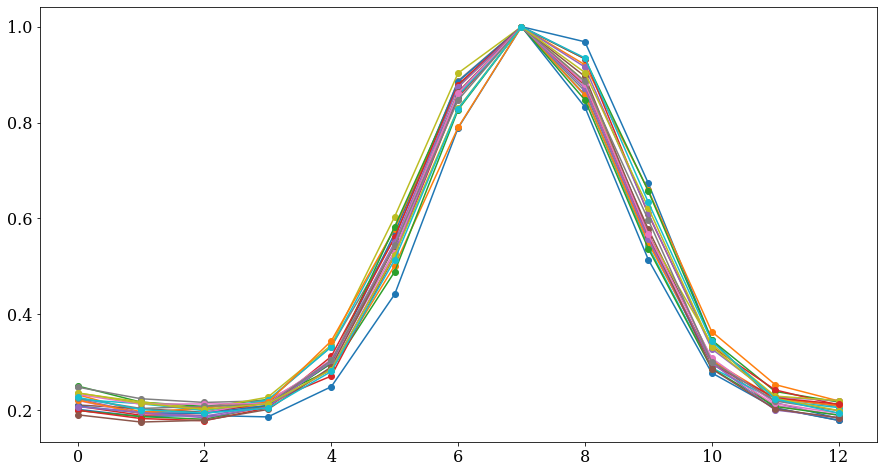

In [3]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)

order = 45
data = hdu1[1].data.copy()
data_spec       = data['spectrum'][order]
data_spec_err   = data['uncertainty'][order]
data_wavel      = data['wavelength'][order]

# Find peaks
peak_info = func_find_peaks(data_spec, 11, 0.15)
peak_locs = peak_info[0]

# Create data slices around each peak
peak_index_ranges = get_peak_index_ranges(peak_locs)

# # Fit peak in each data slice
# peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

# # Get list of true wavelengths
# wavel_true = get_true_wavel(data_wavel, peak_locs)[:, 0] # second column is the n in the true wavel peak formula

plt.figure(figsize=(15,8))

# for peak_n in range(0, len(peak_locs)):
for peak_n in range(20, 40):
    xmin, xmax = peak_index_ranges[peak_n]
    xrange = np.arange(xmin, xmax)
    peak_data = data_spec[xrange]
    peak_data = peak_data / max(peak_data)
    xrange = xrange - xmin
    plt.plot(xrange, peak_data, "-o")


All data points are collected... Let's fit and then use the fit mean to align them:

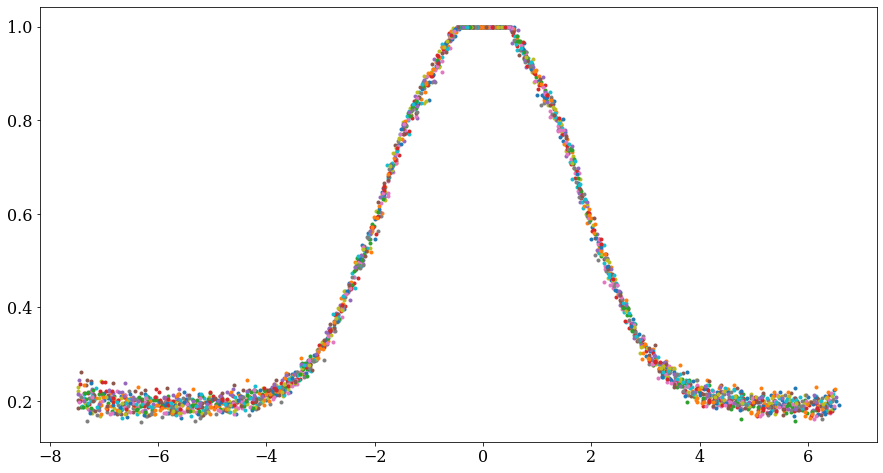

In [4]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)

order = 47
data = hdu1[1].data.copy()
data_spec       = data['spectrum'][order]
data_spec_err   = data['uncertainty'][order]
data_wavel      = data['wavelength'][order]

# Find peaks
peak_info = func_find_peaks(data_spec, 11, 0.15)
peak_locs = peak_info[0]

# Create data slices around each peak
peak_index_ranges = get_peak_index_ranges(peak_locs, peak_range_size = 14)    # TODO: find dynamic way of choosing range size

# Fit peak in each data slice
peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)
fit_means = peak_fits[:, 2]

# Get list of true wavelengths
# wavel_true = get_true_wavel(data_wavel, peak_locs)[:, 0] # second column is the n in the true wavel peak formula

plt.figure(figsize=(15,8))

# for peak_n in range(0, len(peak_locs)):
x = []
y = []
ey = []
for peak_n in range(20, 200):
    xmin, xmax = peak_index_ranges[peak_n]
    xrange = np.arange(xmin, xmax)
    peak_data = data_spec[xrange]
    peak_data_err = data_spec_err[xrange]
    peak_data = peak_data / max(peak_data)
    xrange = xrange - fit_means[peak_n]
    plt.plot(xrange, peak_data, ".")
    x.append(xrange)
    y.append(peak_data)
    ey.append(peak_data_err)


x = np.concatenate(x)
y = np.concatenate(y)
ey = np.concatenate(ey)

Let's fit this with a supergaus

$$
f(x)=A \exp \left(-\left(\frac{\left(x-x_{0}\right)^{2}}{2 \sigma_{X}^{2}}\right)^{P}\right)
$$

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.12e+05                   │              Nfcn = 144              │
│ EDM = 2.18e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

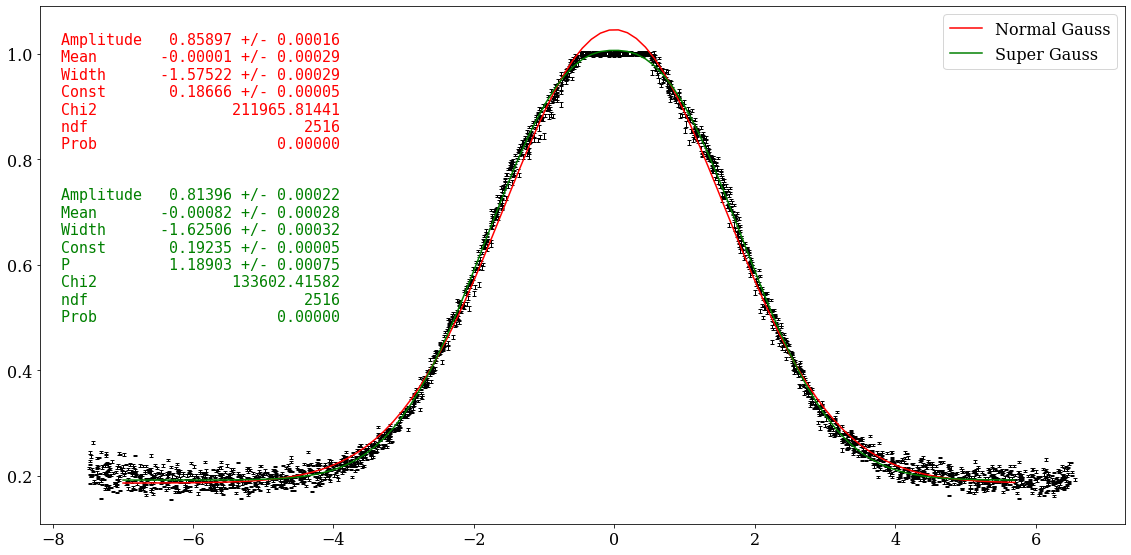

In [83]:
x = x
y = y
ey = ey

# Plot data in errorbars
figPeak, axPeak = plt.subplots(figsize=(16, 8))
axPeak.errorbar(x, y, ey, fmt='none', ecolor='k', linewidth=1, capsize=2, capthick=1)


# ======== FIT NORMAL GAUS ================

# Fitting functions:
def func_GaussConst(x, A, mu, sigma, C) :
    return A * np.exp(-0.5 * (((x)-mu)/sigma)**2)  +  C


# ChiSquare fit model:
def model_chi(A, mu, sigma, C) :
    y_fit = func_GaussConst(x, A, mu, sigma, C)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
model_chi.errordef = 1


# Fit peak with a Gaussian:
A_init     = 0.45
mu_init    = np.mean(x)
sigma_init = -1.6
C_init     = 0.02
minuit = Minuit(model_chi, A=A_init, mu=mu_init, sigma=sigma_init, C=C_init)

# Perform the actual fit (and save the parameters):
m = minuit.migrad()                                             
print(m)
# minuit_output = [minuit.fmin, minuit.params]    # Save the output parameters in case needed
    
# Extract the fitting parameters and their uncertainties:
mu_fit = minuit.values['mu']
sigma_mu_fit = minuit.errors['mu']
Npoints = len(x)
Nvar = 4                                        # Number of variables
Ndof_fit = Npoints - Nvar                       # Number of degrees of freedom = Number of data points - Number of variables
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
print(f"  Peak fitted. N = {Npoints:2d}   Chi2 ={Chi2_fit:5.1f}   Wave mean = {mu_fit:8.3f}+-{sigma_mu_fit:5.3f}")

# Plot fit
xPeak = np.linspace(x[0], x[len(x)-1], 100)
axPeak.plot(xPeak, func_GaussConst(xPeak, *minuit.values[:]), '-r', label="Normal Gauss")

d = {'Amplitude':[minuit.values['A'], minuit.errors['A']],
     'Mean':     [minuit.values['mu'], minuit.errors['mu']],
     'Width':    [minuit.values['sigma'], minuit.errors['sigma']],
     'Const':    [minuit.values['C'], minuit.errors['C']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }
text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.02, 0.95, text, axPeak, fontsize=15, color='r')


# ======== FIT SUPER GAUS ================

# From Christian
 
    # return A * np.exp(-z**P) + C + b * (x - mu)


# ChiSquare fit model:
def model_chi(A, mu, sigma, P, C) :
    y_fit = super_gauss(x, A, mu, sigma, P, C)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
model_chi.errordef = 1


# Fit peak with a Gaussian:
A_init     = 0.45
mu_init    = np.mean(x)
sigma_init = -1.6
P_init     = 1
C_init     = 0.02

minuit = Minuit(model_chi, A=A_init, mu=mu_init, sigma=sigma_init, P=P_init, C=C_init)

# Perform the actual fit (and save the parameters):
m = minuit.migrad()                                             
print(m)
# minuit_output = [minuit.fmin, minuit.params]    # Save the output parameters in case needed
    
# Extract the fitting parameters and their uncertainties:
mu_fit = minuit.values['mu']
sigma_mu_fit = minuit.errors['mu']
Npoints = len(x)
Nvar = 4                                        # Number of variables
Ndof_fit = Npoints - Nvar                       # Number of degrees of freedom = Number of data points - Number of variables
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
print(f"  Peak fitted. N = {Npoints:2d}   Chi2 ={Chi2_fit:5.1f}   Wave mean = {mu_fit:8.3f}+-{sigma_mu_fit:5.3f}")

# Plot fit
xPeak = np.linspace(x[0], x[len(x)-1], 100)
axPeak.plot(xPeak, super_gauss(xPeak, *minuit.values[:]), '-g', label="Super Gauss")

d = {'Amplitude':[minuit.values['A'], minuit.errors['A']],
     'Mean':     [minuit.values['mu'], minuit.errors['mu']],
     'Width':    [minuit.values['sigma'], minuit.errors['sigma']],
     'Const':    [minuit.values['C'], minuit.errors['C']],
     'P':        [minuit.values['P'], minuit.errors['P']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }
text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.02, 0.65, text, axPeak, fontsize=15, color='g')

axPeak.legend()
figPeak.tight_layout()





Run for all orders 

In [62]:
def compute_mean_diffs(order):

    data_spec       = data['spectrum'][order]
    data_spec_err   = data['uncertainty'][order]
    data_wavel      = data['wavelength'][order]

    # Find peaks
    peak_info = func_find_peaks(data_spec, 11, 0.15)
    peak_locs = peak_info[0]

    # Create data slices around each peak
    peak_index_ranges = get_peak_index_ranges(peak_locs, peak_range_size = 14)    # TODO: find dynamic way of choosing range size

    # Fit peak in each data slice
    peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)
    fit_means = peak_fits[:, 2]

    x = []
    y = []
    ey = []
    for peak_n in range(20, 200):
    # for peak_n in range(0, int(len(peak_locs) * 2/3)):
        xmin, xmax = peak_index_ranges[peak_n]
        xrange = np.arange(xmin, xmax)
        peak_data = data_spec[xrange]
        peak_data_err = data_spec_err[xrange]
        peak_data = peak_data / max(peak_data)
        xrange = xrange - fit_means[peak_n]
        x.append(xrange)
        y.append(peak_data)
        ey.append(peak_data_err)


    x = np.concatenate(x)
    y = np.concatenate(y)
    ey = np.concatenate(ey)


    figPeak, axPeak = plt.subplots(figsize=(12, 5))
    axPeak.errorbar(x, y, ey, fmt='none', ecolor='k', linewidth=1, capsize=2, capthick=1)

    # ======== FIT NORMAL GAUS ================

    # Fitting functions:
    def func_GaussConst(x, A, mu, sigma, C) :
        return A * np.exp(-0.5 * (((x)-mu)/sigma)**2)  +  C


    # ChiSquare fit model:
    def model_chi(A, mu, sigma, C) :
        y_fit = func_GaussConst(x, A, mu, sigma, C)
        chi2 = np.sum(((y - y_fit) / ey)**2)
        return chi2
    model_chi.errordef = 1

    A_init     = 0.45
    mu_init    = np.mean(x)
    sigma_init = -1.6
    C_init     = 0.02

    minuit = Minuit(model_chi, A=A_init, mu=mu_init, sigma=sigma_init, C=C_init)
    m = minuit.migrad()                                             
        
    # Extract the fitting parameters and their uncertainties:
    gaus_mu_fit = minuit.values['mu']
    gaus_sigma_mu_fit = minuit.errors['mu']
    
    xPeak = np.linspace(x[0], x[len(x)-1], 100)
    axPeak.plot(xPeak, func_GaussConst(xPeak, *minuit.values[:]), '-g', label="Normal Gauss")

    Npoints = len(x)
    Nvar = 4                                        # Number of variables
    Ndof_fit = Npoints - Nvar                       # Number of degrees of freedom = Number of data points - Number of variables
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
    d = {'Amplitude':[minuit.values['A'], minuit.errors['A']],
     'Mean':     [minuit.values['mu'], minuit.errors['mu']],
     'Width':    [minuit.values['sigma'], minuit.errors['sigma']],
     'A':       [minuit.values['A'], minuit.errors['A']],
     'Const':    [minuit.values['C'], minuit.errors['C']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }
    text = nice_string_output(d, extra_spacing=2, decimals=5)
    add_text_to_ax(0.02, 0.95, text, axPeak, fontsize=11, color='g')

    # ======== FIT SUPER GAUS ================

    # From Christian
    def super_gauss(x, A, mu, sigma, P, C, b = 0):
        z = (x - mu)**2 / (2 * sigma**2)
        return A * np.exp(-z**P) + C + b * (x - mu)


    # ChiSquare fit model:
    def model_chi(A, mu, sigma, P, C) :
        y_fit = super_gauss(x, A, mu, sigma, P, C)
        chi2 = np.sum(((y - y_fit) / ey)**2)
        return chi2
    model_chi.errordef = 1

    A_init     = 0.87
    mu_init    = np.mean(x)
    sigma_init = -1.8
    P_init     = 1.3
    C_init     = 0.12

    minuit = Minuit(model_chi, A=A_init, mu=mu_init, sigma=sigma_init, P=P_init, C=C_init)
    minuit.migrad()                                             
        
    # Extract the fitting parameters and their uncertainties:
    super_mu_fit = minuit.values['mu']
    super_sigma_mu_fit = minuit.errors['mu']

    xPeak = np.linspace(x[0], x[len(x)-1], 100)
    axPeak.plot(xPeak, super_gauss(xPeak, *minuit.values[:]), '-r', linewidth=2, label="Super Gauss")

    Npoints = len(x)
    Nvar = 4                                        # Number of variables
    Ndof_fit = Npoints - Nvar                       # Number of degrees of freedom = Number of data points - Number of variables
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
    d = {'Amplitude':[minuit.values['A'], minuit.errors['A']],
     'Mean':     [minuit.values['mu'], minuit.errors['mu']],
     'Width':    [minuit.values['sigma'], minuit.errors['sigma']],
     'Const':    [minuit.values['C'], minuit.errors['C']],
     'P':        [minuit.values['P'], minuit.errors['P']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }
    text = nice_string_output(d, extra_spacing=2, decimals=5)
    add_text_to_ax(0.68, 0.95, text, axPeak, fontsize=11, color='r')

    return gaus_mu_fit, gaus_sigma_mu_fit, super_mu_fit, super_sigma_mu_fit, minuit.values['P'], minuit.errors['P']

/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_38889/1879316522.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figPeak, axPeak = plt.subplots(figsize=(12, 5))


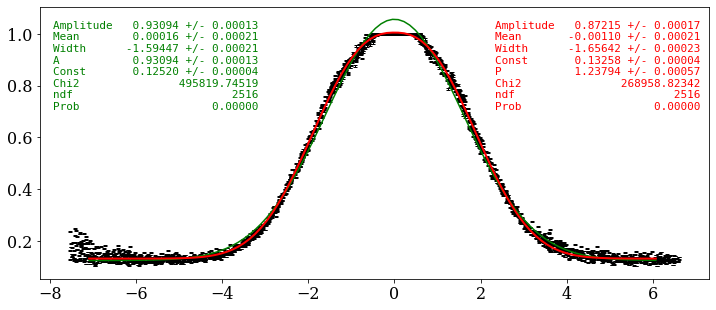

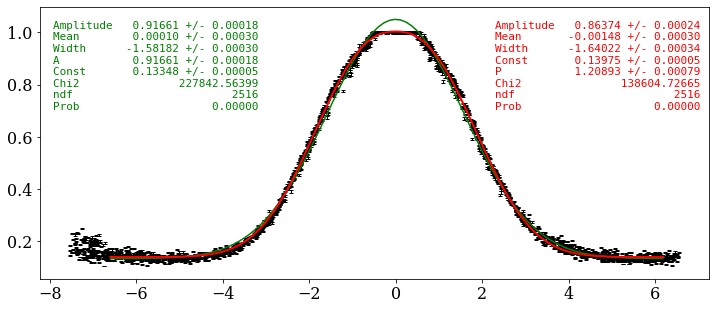

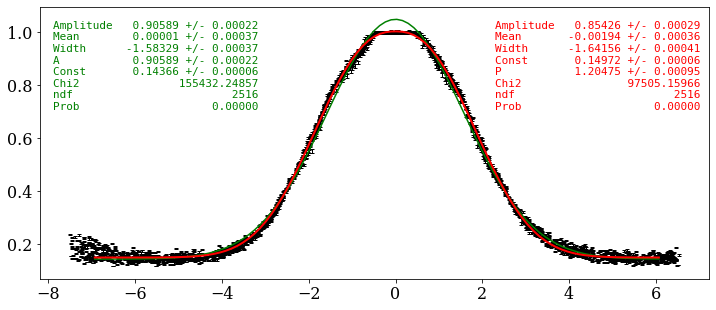

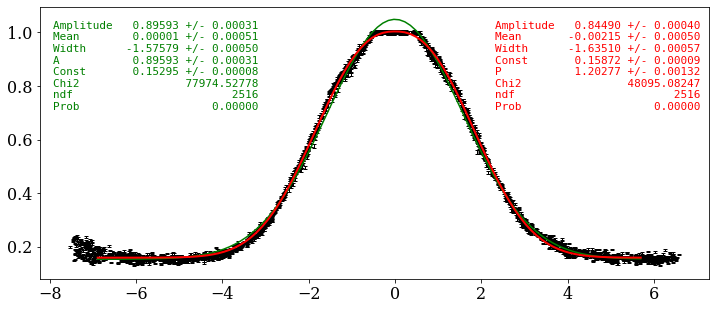

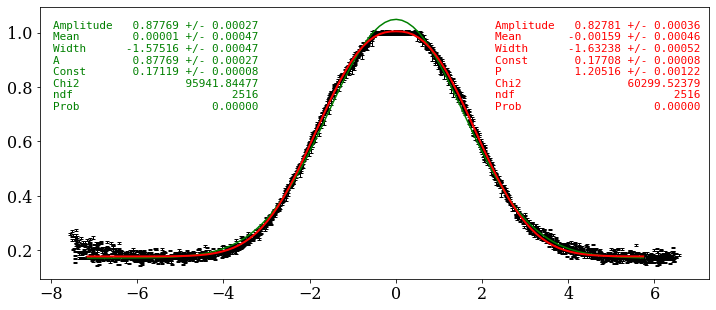

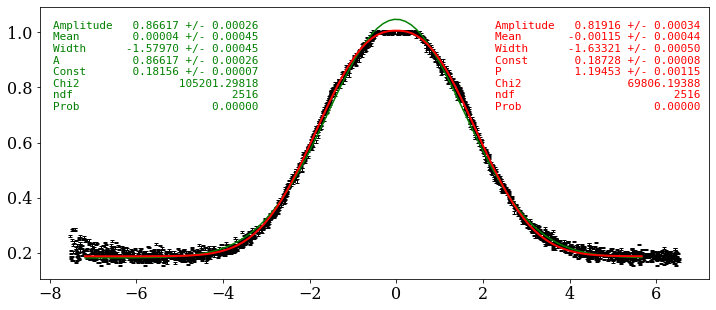

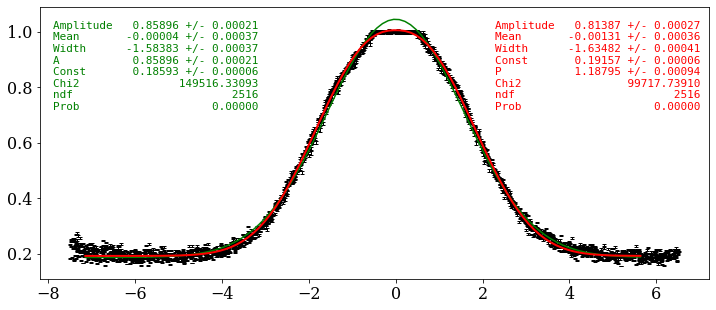

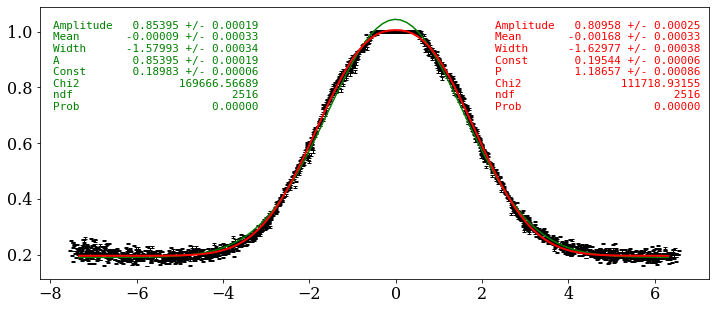

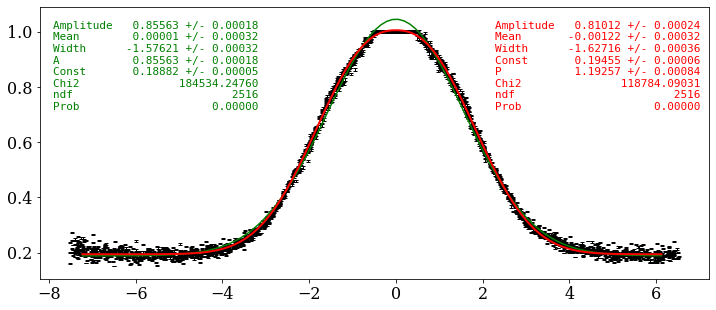

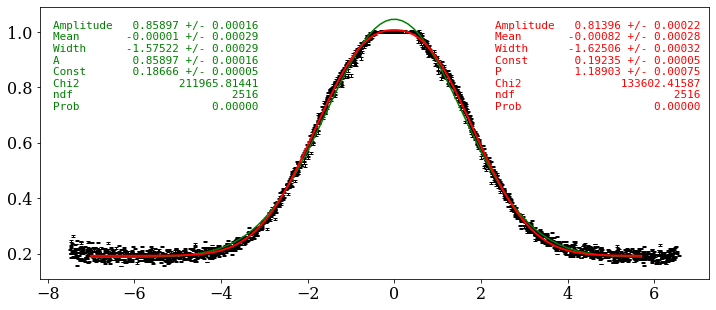

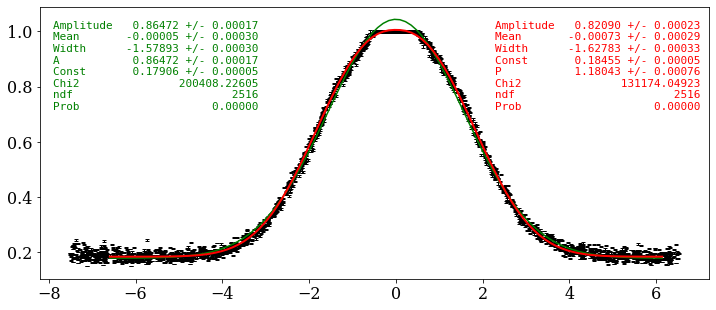

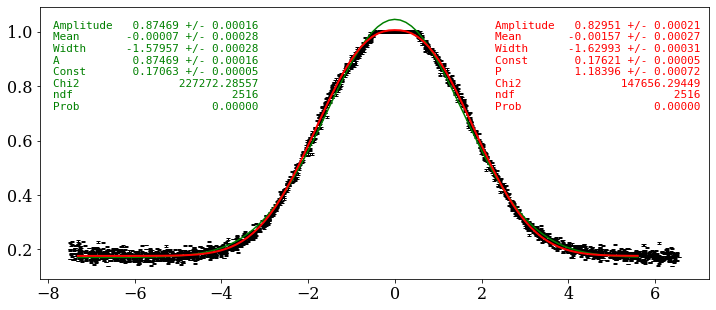

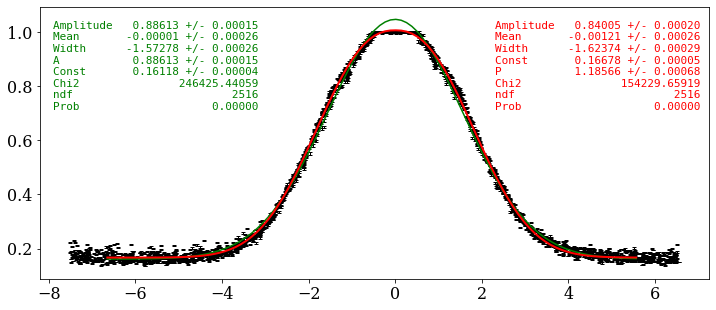

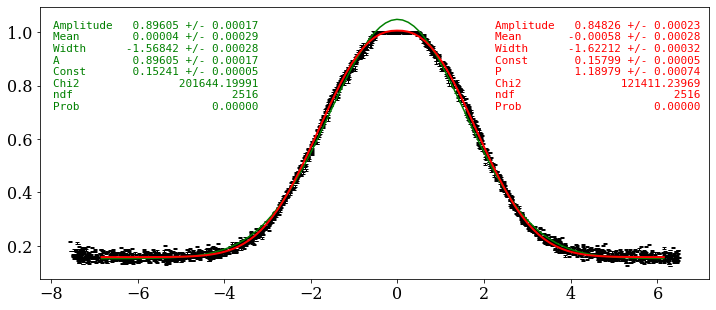

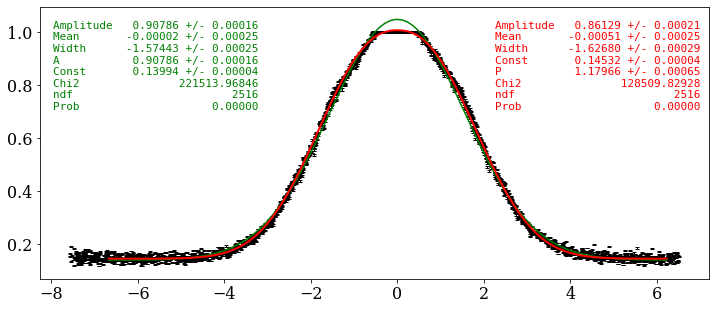

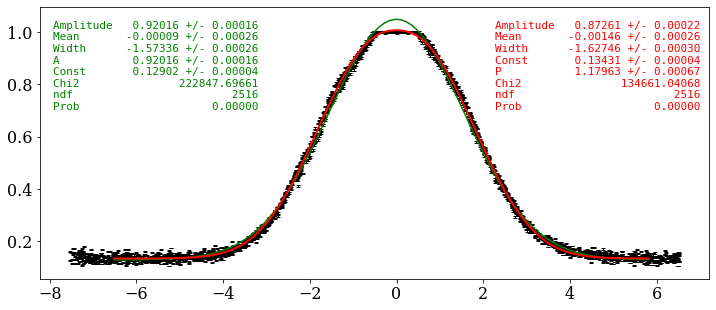

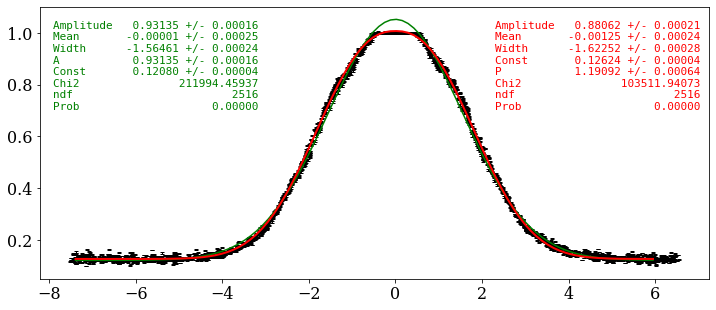

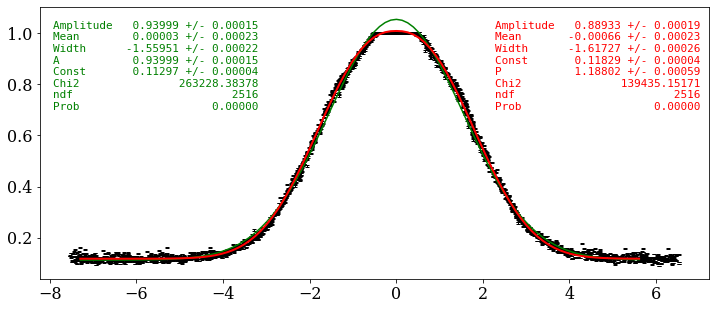

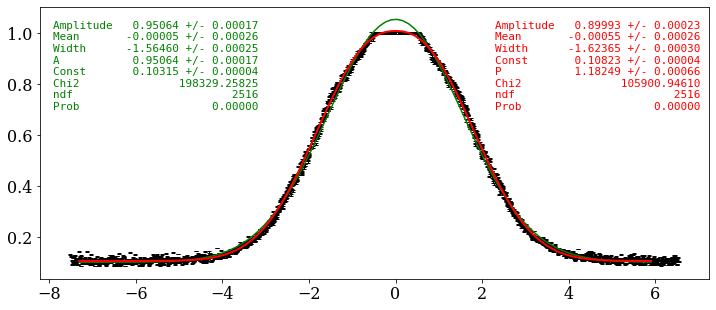

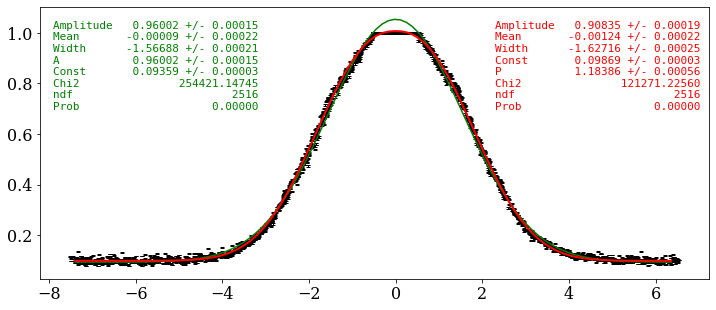

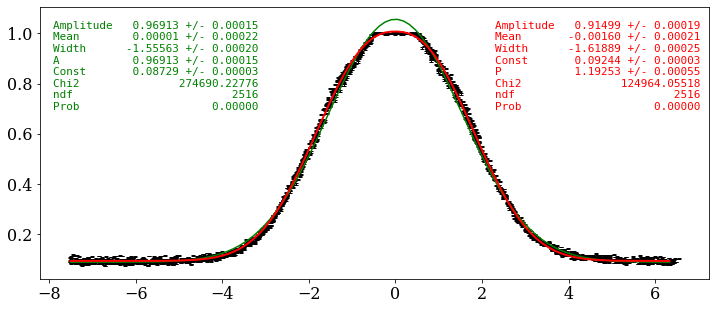

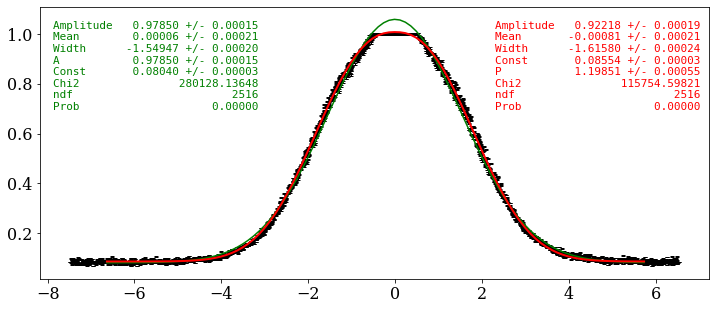

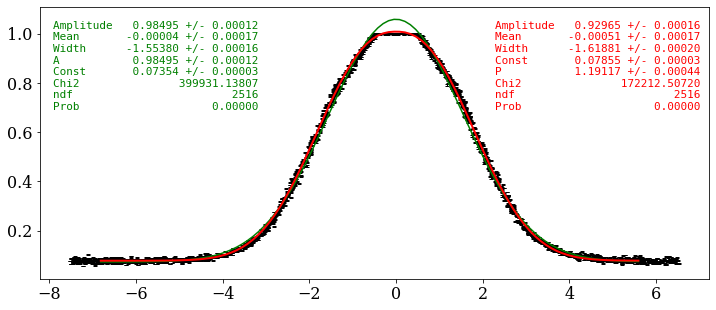

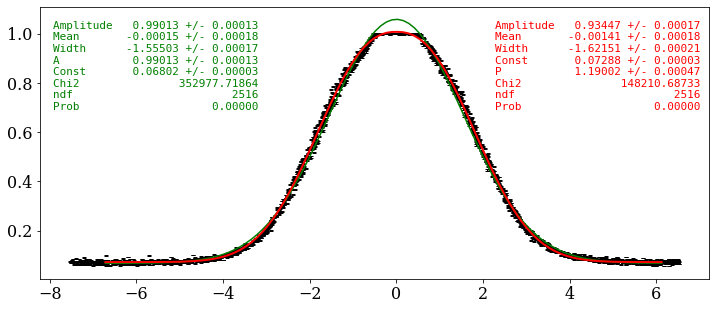

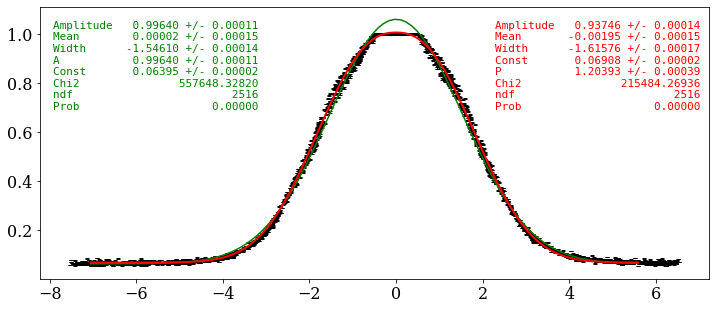

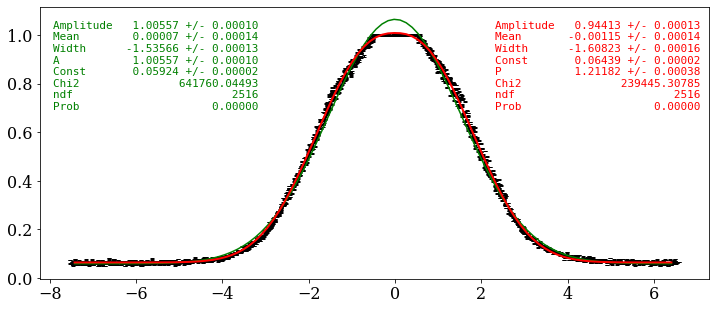

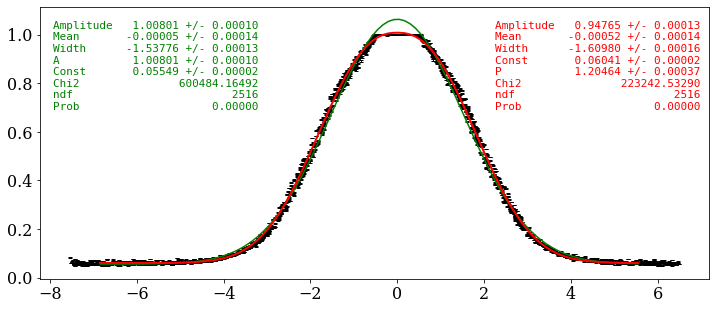

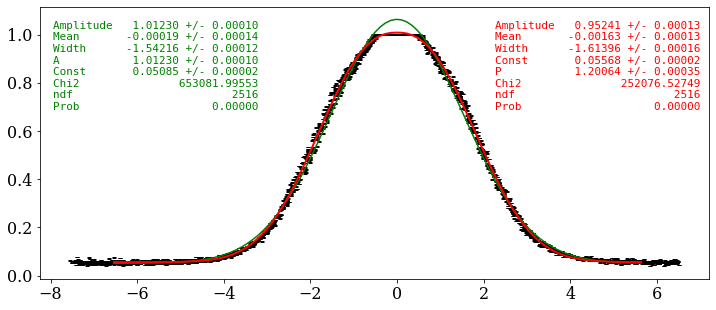

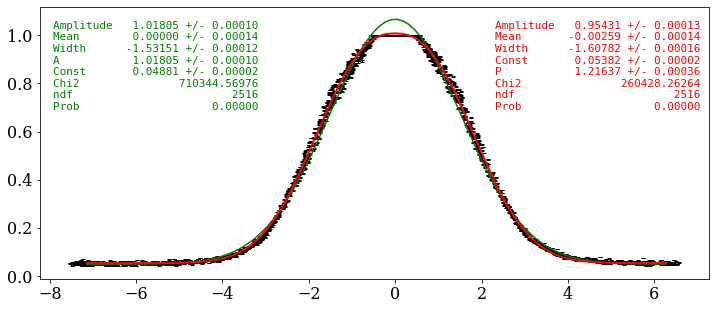

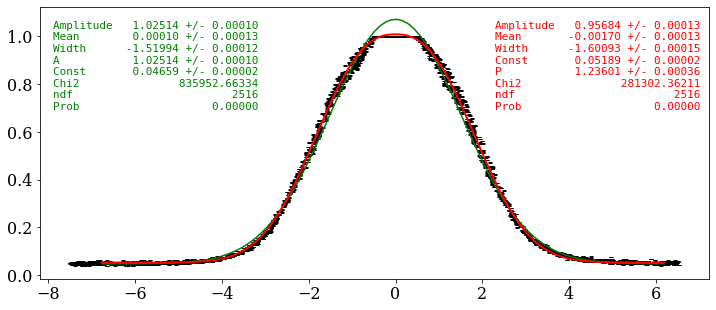

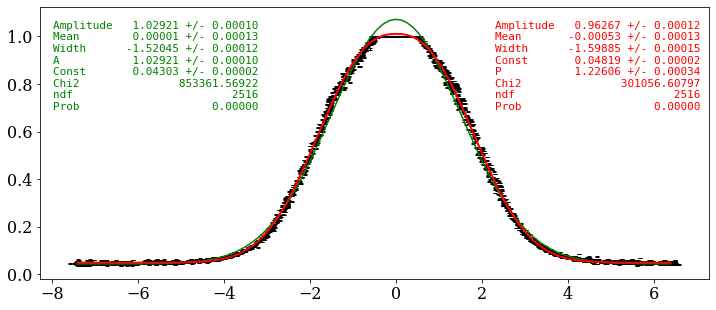

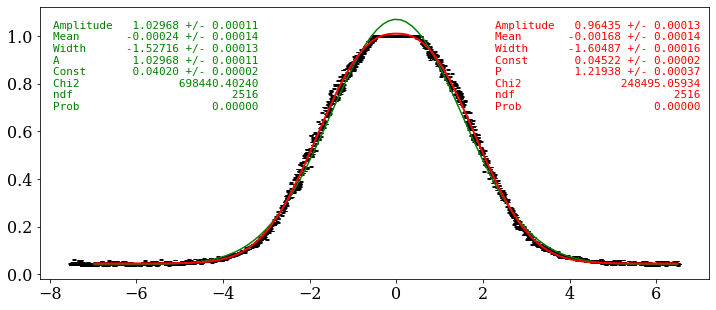

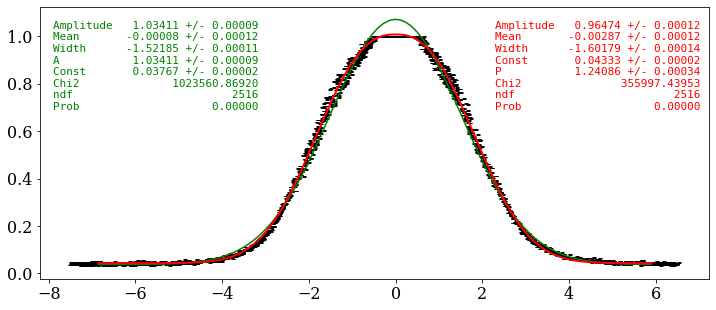

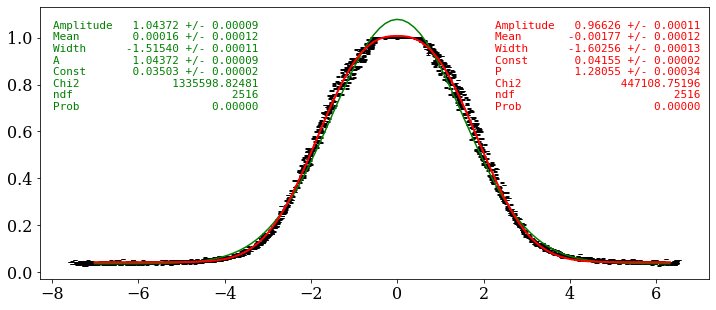

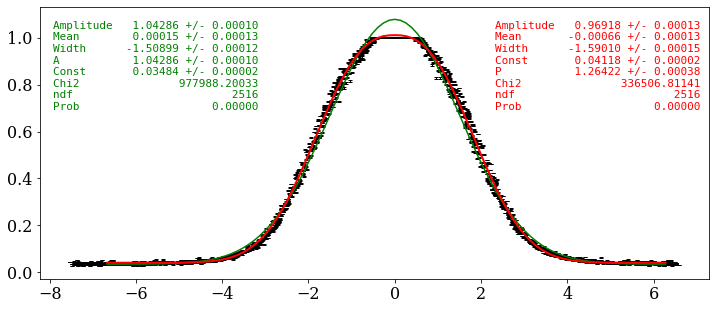

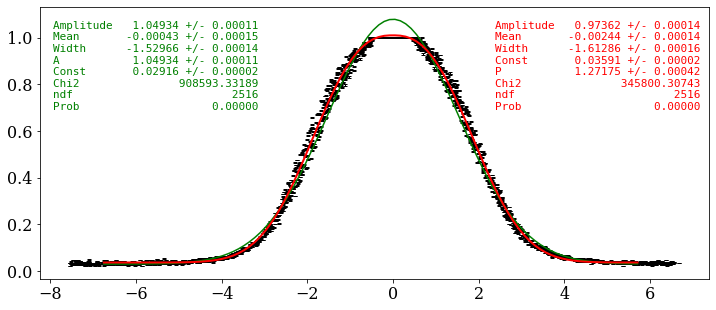

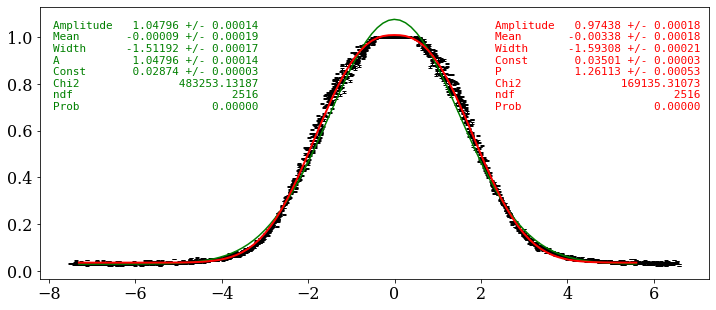

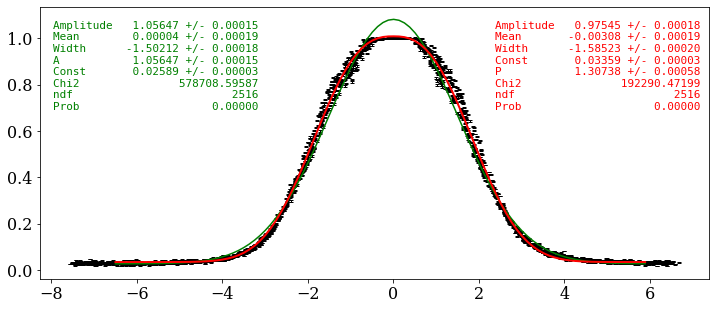

In [63]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)
data = hdu1[1].data.copy()

res = []
for order in range(38, 76):
    res.append([*compute_mean_diffs(order)])
res = np.asarray(res)

#### Plot difference between mu from gauss and super gauss as a function of order

Text(0, 0.5, 'P')

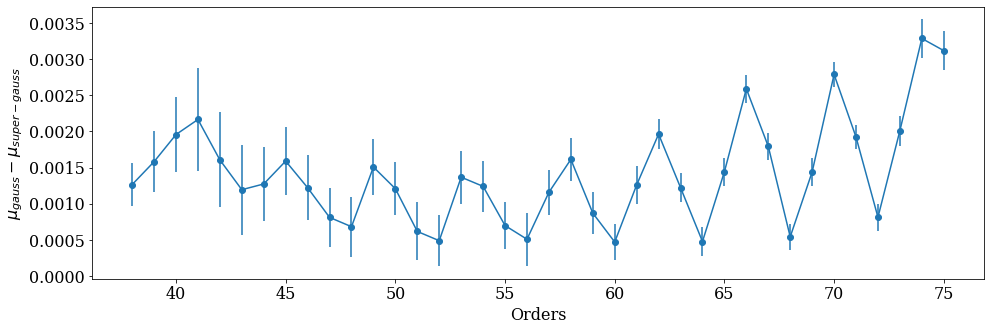

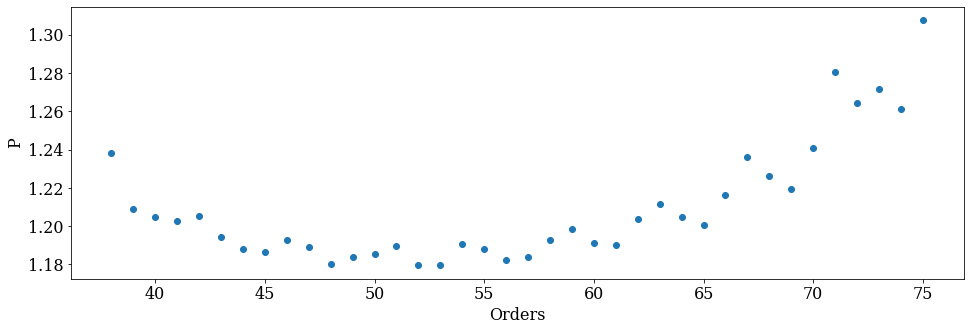

In [85]:

gaus_mu_fit, gaus_sigma_mu_fit, super_mu_fit, super_sigma_mu_fit, P, P_err = res[:, 0], res[:, 1], res[:, 2], res[:, 3], res[:, 4], res[:, 5]
mu_diff = gaus_mu_fit - super_mu_fit
mu_diff_err = np.sqrt(gaus_sigma_mu_fit **2 + super_sigma_mu_fit ** 2)

# mu_diff = mu_diff[mu_diff != 0] # Remove 0s 

# Plot mean diff between gauss and super gauss as function of order
fig, ax = plt.subplots(figsize=(16,5))
ax.errorbar(range(38, 76), mu_diff, yerr=mu_diff_err, fmt="-o");
ax.set_xlabel("Orders")
ax.set_ylabel("$\mu_{gauss} - \mu_{super-gauss}$")


# Plot P as function of order
fig, ax = plt.subplots(figsize=(16,5))
ax.errorbar(range(38, 76), P, yerr=P_err, fmt="o")
ax.set_xlabel("Orders")
ax.set_ylabel("P")